# 知识工程-作业10 英法中文翻译
2024214500 叶璨铭


## 代码与文档格式说明

> 本文档使用Jupyter Notebook编写，遵循Diátaxis 系统 Notebook实践 https://nbdev.fast.ai/tutorials/best_practices.html，所以同时包括了实验文档和实验代码。

> 本文档理论上支持多个格式，包括ipynb, docx, pdf 等。您在阅读本文档时，可以选择您喜欢的格式来进行阅读，建议您使用 Visual Studio Code (或者其他支持jupyter notebook的IDE, 但是VSCode阅读体验最佳) 打开 `ipynb`格式的文档来进行阅读。

> 为了记录我们自己修改了哪些地方，使用git进行版本控制，这样可以清晰地看出我们基于助教的代码在哪些位置进行了修改，有些修改是实现了要求的作业功能，而有些代码是对原本代码进行了重构和优化。我将我在知识工程课程的代码，在作业截止DDL之后，开源到 https://github.com/2catycm/THU-Coursework-Knowledge-Engineering.git ，方便各位同学一起学习讨论。


## 代码规范说明

在我们实现函数过程中，函数的docstring应当遵循fastai规范而不是numpy规范，这样简洁清晰，不会Repeat yourself。相应的哲学和具体区别可以看 
https://nbdev.fast.ai/tutorials/best_practices.html#keep-docstrings-short-elaborate-in-separate-cells


为了让代码清晰规范，在作业开始前，使用 `ruff format`格式化助教老师给的代码; 

![alt text](image.png)


很好，这次代码格式化没有报错。

Pylance 似乎也没有明显问题。

## 实验环境准备

采用上次的作业专属环境，为了跑通最新方法，使用3.12 和 torch 2.7

```bash
conda create -n assignments python=3.12
conda activate assignments
pip install -r ../requirements.txt
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
pip install -U git+https://github.com/TorchRWKV/flash-linear-attention
```

本次作业似乎没有新的依赖，只是用到了 torch


## 原理回顾和课件复习



课上详细介绍了 概述、传统、统计、神经方法

概述中，注意到“平行语料库”这个概念，平行语料库（Parallel Corpus）是指在两个或多个语言之间具有对齐关系的文本集合。每对对应的文本在不同语言中表达了相同或相似的意义，因而可以用于语言间的比较、翻译模型的训练、语言学研究以及其他自然语言处理任务。罗塞塔石碑就是典型例子，罗塞塔石碑是一块刻有相同内容但用三种不同书写系统（古埃及象形文字、埃及民用文和古希腊文）的石碑。正是因为这些文本内容一致，学者们才能利用已知语言（古希腊文）的信息，逐步破译不明的古埃及象形文字，揭开了古埃及语言和文化的神秘面纱。

1947年，机器翻译认为是解读密码。1966年陷入低迷，1978年恢复。

难点是语言表达有歧义、文化有差异、翻译和知识、常识有关、解不唯一、新词和专有名词。

简单直接翻译方法直接替换已知的单词、短语、句子，然后调整顺序。

基于规则的方法用规则描述语法，对句子进行词法分析（把连续的字符序列划分成独立的词或符号（即“词元”或“标记”））、句法分析（在词法分析的基础上，利用预先定义的语法规则构造句子的句法结构（如语法树），确定不同词汇之间的组合规则和结构关系。）、语义分析（不仅关注词语的基本含义，还要判断它们在上下文中的语境作用，识别歧义、隐含意义和语义角色）。生成译文的句子结构（两个语言表达顺序不同），然后选择词法。
也叫作基于Transform的方法，这是独立分析两个语言的结构。缺点是语言写得不符合预定义的语法的时候处理不了。

注意，基于规则的方法无需依赖双语平行语料。（？需要词典，词典不算吗）

基于实例的方法，会类比已有的标准翻译实例，然后拼凑新的翻译。


基于统计的翻译，使用噪声信道模型。从S翻译到T，认为是T经过噪声干扰变成了S。求 P(T|S)， 
可以求 P(S|T) 和 P(T) 后者直接统计词频。










## 数据准备

助教已经帮我们preprocess好了数据，注意到有四个json文件。有两个是单词编码为id，词典对照。
train和valid是 jsonl 的格式， 一行是一个 句子翻译到一个句子。

![alt text](image-1.png)

## 补充完成`./metrics.py`中BLEU的计算

首先了解一下BLEU的概念, 参考课件和 https://en.wikipedia.org/wiki/BLEU 。

BLEU 全称 bilingual evaluation understudy，雙語替換評測，“Understudy”在这里指的是“替补演员”，在戏剧、表演等领域，指那些在正式演员因故无法出演时，能够随时顶替其角色的演员。

想要评测 Quality/correspondence/accuracy。 wiki说是2001, 课件是2002， IBM发明。不考虑可理解性、语法正确性，只考虑与参考答案（有一组， a set of good quality reference translations）像不像。输出[0,1]。数据集=语料库 corpus，有多个翻译预测和多组翻译参考答案。


首先需要指定 N-Gram 的 N，对于字符串，可以找到 其 N-Grams 的（不重复）集合。
![alt text](image-2.png)


然后定义出现次数C
![alt text](image-3.png)

S有M个预测答案，M组参考答案。
![alt text](image-4.png)

首先定义 Modified N-Gram Precision，既然是Precision，不是Recall，所以就是从预测答案来看

在预测的答案中，每一个N-Gram出现了很多次，对于每一个N-Gram而言，想看看在标准答案里面出现多少次，如果比我少，那我不准，我做多了，可能凭空翻译了新东西。有一组标准答案，所以里面对我最好的那个（出现我的ngram最多的那个）和我比。
![alt text](image-5.png)

这个式子另一个角度看，是为了衡量，参考句子多少个n gram时候是在 候选句子中有的，有多少次。

有了 Modified N-Gram Precision 之后，BLEU引入 Brevity penalty  简洁性惩罚（不是惩罚之后变简洁，而是简洁的被惩罚）。

因为刚才的指标不恰当地（unduly）会奖励那种为了拿分全部N-Gram都说一遍（telegraphic）的模型。

仔细看了看，我理解错了，惩罚的是有N-Gram，但是只说一遍，后面忘记说了的模型。


![alt text](image-6.png)

乍一看，
r是 real 的长度（一组里面最接近c的那个），c是candidate的长度。

如果c比r长就不惩罚了（我说的那个问题好像不是这里解决）

实际上，
需要注意BP是对整个语料库算的，不是对单个句子！是求了个和！整体进行惩罚！

![alt text](image-7.png)

![alt text](image-8.png)

最终，BLEU 认为 很多 N Gram都重要，要加权算，所以枚举n=1到无穷，有wn分布来加权，得到

![alt text](image-9.png)

几何平均数是希望，模型不是只在一个N Gram上表现好，而是大部分都好。

原本论文只考虑 n=1, 2, 3, 4, w = 1/4 。


 批评BLEU的意见指出，没有分词边界的语言，或者英语使用不同的token方案，会导致BLEU分数差异很大，不可比较。

现在我们来实现，首先观察助教给的函数签名，顿时发现了问题

candidate_corpus: List[List[str]]      # 形如 [[cand1_token1, cand1_token2, …], [cand2_…], …]
references_corpus: List[List[str]]     # 同样是 [[ref1_token1, ref1_token2, …], [ref2_…], …]

首先每一个 str 是 一个 token， 不是 句子哦， List[str] 是一个句子。

第二，这里是一对一的，没有上面概念里面的 一个 candidate，多个 reference 的情况。

In [ ]:
def bleu_score(
    candidate_corpus: List[List[str]],  # 候选翻译的token列表的列表。
    references_corpus: List[
        List[str]
    ],  # 参考翻译的token列表的列表，数量应与候选一一对应。
    max_n=4,  # 最大的ngram的数量，默认4。
    weights: List[float] = [0.25]
    * 4,  # 用于计算加权几何平均时的权重列表，长度应为max_n。
    verbose: bool = True,
) -> float:  # BLEU分数（0到1之间）。
    """
    计算候选翻译语料库和参考翻译语料库之间的BLEU分数。
    """
    assert len(candidate_corpus) == len(references_corpus), (
        "候选翻译和参考翻译的数量必须一致。"
    )
    assert len(weights) == max_n, "权重列表的长度必须等于最大的ngram数量。"

    total_clip_count = [0] * max_n
    total_candidate_ngrams = [0] * max_n
    total_candidate_length = 0
    total_reference_length = 0

    for candidate, references in zip(candidate_corpus, references_corpus):
        candidate_ngrams = _compute_ngram_counter(candidate, max_n)
        reference_ngrams = [_compute_ngram_counter(ref, max_n) for ref in references]
        max_reference_ngrams = collections.Counter()
        for ref_ngrams in reference_ngrams:
            for ngram, count in ref_ngrams.items():
                max_reference_ngrams[ngram] = max(max_reference_ngrams[ngram], count)

        for n in range(1, max_n + 1):
            for ngram, count in candidate_ngrams.items():
                if len(ngram) == n:
                    total_candidate_ngrams[n - 1] += count
                    total_clip_count[n - 1] += min(count, max_reference_ngrams[ngram])

        candidate_length = len(candidate)
        total_candidate_length += candidate_length
        reference_lengths = [len(ref) for ref in references]
        closest_ref_length = min(
            reference_lengths, key=lambda x: abs(x - candidate_length)
        )
        total_reference_length += closest_ref_length

    precisions = []
    for clip_count, candidate_ngrams in zip(total_clip_count, total_candidate_ngrams):
        if candidate_ngrams == 0:
            precisions.append(0)
        else:
            precisions.append(clip_count / candidate_ngrams)

    if verbose:
        print(f"Precisions: {precisions}")
        print(f"Total candidate length: {total_candidate_length}")
        print(f"Total reference length: {total_reference_length}")

    if total_candidate_length == 0:
        return 0

    brevity_penalty = (
        1
        if total_candidate_length >= total_reference_length
        else math.exp(1 - total_reference_length / total_candidate_length)
    )

    if verbose:
        print(f"Brevity penalty: {brevity_penalty}")

    log_precisions = [math.log(p) if p > 0 else float("-inf") for p in precisions]
    bleu = brevity_penalty * math.exp(
        sum(w * p for w, p in zip(weights, log_precisions))
    )

    return bleu

简单测试一下。

In [1]:
from metrics import bleu_score

# 示例候选翻译语料库
candidate_corpus = [["the", "cat", "sat", "on", "the", "mat"], ["hello", "world"]]
# 示例参考翻译语料库
references_corpus = [
    [["the", "cat", "is", "sitting", "on", "the", "mat"]],
    [["hello", "world"]],
]

score = bleu_score(candidate_corpus, references_corpus)
score

Precisions: [0.875, 0.6666666666666666, 0.25, 0.0]
Total candidate length: 8
Total reference length: 9
Brevity penalty: 0.8824969025845955


0.0

可以发现，因为句子太短，没有 4-Gram! BLEU 分数为 0 的原因是 4-gram 的精确率为 0，导致其对数为负无穷（log(0) = -inf），最终加权平均后的指数部分为负无穷，使得整体结果为 0。这是符合数学定义的，并非代码错误。

测试用例中，第一个候选翻译 ["the", "cat", "sat", "on", "the", "mat"] 和参考翻译 ["the", "cat", "is", "sitting", "on", "the", "mat"] 的 4-gram 必然无法匹配（候选长度为 6，4-gram 数量为 3；参考长度为 7，4-gram 数量为 4），因此 4-gram 精确率为 0 是合理的。
BLEU 分数的数学定义中，只要任意 n-gram 的精确率为 0，其对数会拉低整个指数项，导致结果趋近于 0。这是正常现象。

我们可以让 max_n=3

In [3]:
score = bleu_score(candidate_corpus, references_corpus, max_n=3, weights=[1 / 3] * 3)
score

Precisions: [0.875, 0.6666666666666666, 0.25]
Total candidate length: 8
Total reference length: 9
Brevity penalty: 0.8824969025845955


0.464513981711853

## 阅读`model/transformer.py`并补充完成multihead attention

拿到助教给我们的代码，首先注意到分为 context  和 attention两个部分。

```python
context, attention = None, None
# TODO
return context, attention
```

其实 context就是输出的hidden states, attention 分数是中间结果，可能要可视化吧。

由于维度比较高，难以思考，所以我们决定用 某次作业助教用到的 einops 来尝试实现 这个 attention。


In [ ]:
import torch
import torch.nn as nn
from einops import einsum


class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout):
        """实现Scaled Dot-Product Attention"""
        super(ScaledDotProductAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(dim=-1)

    def forward(
        self,
        q: torch.Tensor,
        k: torch.Tensor,
        v: torch.Tensor,  # [batch_size, num_heads, seq_len, hidden_size / num_heads]
        mask: torch.Tensor  # [batch_size, 1, seq_len, seq_len]
    ):
        """
        output:
            - context: 输出值
            - attention: 计算得到的注意力矩阵
        """
        d_k = q.size(-1)
        sqrt_d_k = torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
        # 计算点积，使用einops的einsum
        
        # b,h 独立，做乘法的是 i,j，
        # d 维度会进行求和操作，因为它只在输入中出现，不在输出中出现（被reduce掉了）。
        scores = einsum(q, k, 'b h i d, b h j d -> b h i j') / sqrt_d_k 

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9) # mask到的位置不能被 attention 注意到，本来是赋值为0，但是待会有softmax，应该给-inf。

        attention = self.softmax(scores)
        attention = self.dropout(attention)

        # 计算context，使用einops的einsum
        # b,h 独立，i， d乘法；对 j 求和
        context = einsum(attention, v, 'b h i j, b h j d -> b h i d')
        return context, attention




注意掩码约定为masks 的形状为 (batch, i, j)，i：代表 查询（Query）的位置（例如，序列中每个 token 作为查询时的索引）；j：代表 键（Key）的位置（例如，序列中每个 token 作为键时的索引）。
掩码 masks[b, i, j] 表示：第 b 个批次中，查询位置 i 能否关注键位置 j（通常为 0 或 1，或用于缩放的权重）。

decoder中，不允许 i 关注 >i 的 j， 所以 mask 是 下三角矩阵，i可以大于j，j不可以大于i。

参考 torch 官网文档 https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html
![alt text](image-10.png)

我们的掩码约定和其一样。


我们可以简单测试一下我们的代码

In [14]:
# 定义参数
batch_size = 2
num_heads = 4
seq_len = 3
hidden_size_per_head = 8
dropout = 0.1

# 创建模拟输入
q = torch.randn(batch_size, num_heads, seq_len, hidden_size_per_head)
k = torch.randn(batch_size, num_heads, seq_len, hidden_size_per_head)
v = torch.randn(batch_size, num_heads, seq_len, hidden_size_per_head)
mask = torch.tril(torch.ones(batch_size, 1, seq_len, seq_len))

# 初始化模型
attention_module = ScaledDotProductAttention(dropout)

# 前向传播
context, attention = attention_module(q, k, v, mask)

print(f"Context shape: {context.shape}")
print(f"Attention shape: {attention.shape}")
print("Test passed!")

Context shape: torch.Size([2, 4, 3, 8])
Attention shape: torch.Size([2, 4, 3, 3])
Test passed!


我们可以可视化一下 attention score

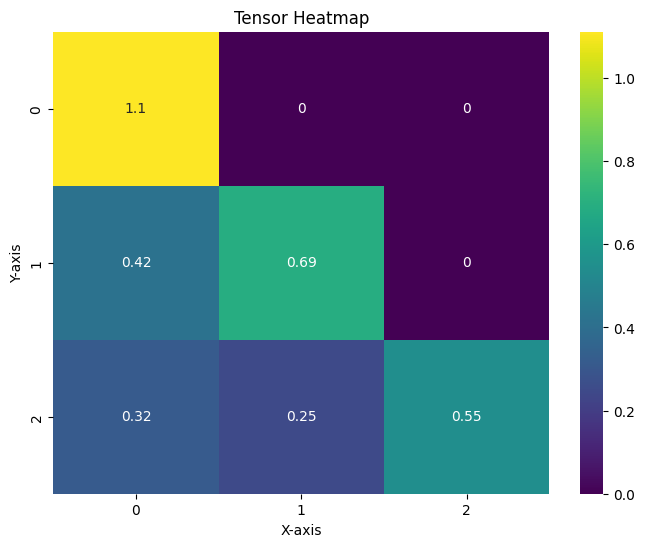

In [15]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 使用seaborn绘制热力图
plt.figure(figsize=(8, 6))
sns.heatmap(attention[0, 0], annot=True, cmap='viridis')
plt.title('Tensor Heatmap')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

现在继续实现多头注意力



In [16]:
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout):
        """实现Multi-Head Attention"""
        super(MultiHeadAttention, self).__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.dropout = dropout
        self.linear_q = nn.Linear(hidden_size, hidden_size)
        self.linear_k = nn.Linear(hidden_size, hidden_size)
        self.linear_v = nn.Linear(hidden_size, hidden_size)
        self.linear = nn.Linear(hidden_size, hidden_size)
        self.scaled_dot_product_attention = ScaledDotProductAttention(dropout)
        self.dropout_layer = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_size)

    def forward(
        self,
        q: torch.Tensor,
        k: torch.Tensor,
        v: torch.Tensor,  # [batch_size, num_heads, seq_len, hidden_size / num_heads]
        mask: torch.Tensor  # [batch_size, 1, seq_len, seq_len]
    ):
        residual = q
        batch_size = q.size(0)

        # 线性变换
        q = self.linear_q(q)
        k = self.linear_k(k)
        v = self.linear_v(v)

        # 分割成多个头
        head_dim = self.hidden_size // self.num_heads
        q = q.view(batch_size, -1, self.num_heads, head_dim).transpose(1, 2)
        k = k.view(batch_size, -1, self.num_heads, head_dim).transpose(1, 2)
        v = v.view(batch_size, -1, self.num_heads, head_dim).transpose(1, 2)

        # 应用缩放点积注意力
        context, attention = self.scaled_dot_product_attention(q, k, v, mask)

        # 拼接多个头的输出
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.hidden_size)

        # 通过线性层
        output = self.linear(context)
        output = self.dropout_layer(output)

        # 残差连接和层归一化
        output = self.layer_norm(output + residual)

        return output, attention

In [17]:
# 定义参数
batch_size = 2
seq_len = 3
hidden_size = 8
num_heads = 4
dropout = 0.1

# 创建模拟输入
q = torch.randn(batch_size, seq_len, hidden_size)
k = torch.randn(batch_size, seq_len, hidden_size)
v = torch.randn(batch_size, seq_len, hidden_size)
mask = torch.tril(torch.ones(batch_size, 1, seq_len, seq_len))

# 初始化多头注意力模块
multi_head_attention = MultiHeadAttention(hidden_size, num_heads, dropout)

# 前向传播
output, attention = multi_head_attention(q, k, v, mask)

# 打印输出形状
print(f"Output shape: {output.shape}")
print(f"Attention shape: {attention.shape}")
print("Test passed!")

Output shape: torch.Size([2, 3, 8])
Attention shape: torch.Size([2, 4, 3, 3])
Test passed!
